# Activation maps of the deep decoder

Here, we visualize the activation maps of the deep decoder (Figure 6 in the paper).

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '4'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor


num GPUs 1


## Load image

In [2]:
path = './test_data/'
img_name = "phantom256"
img_path = path + img_name + ".png"
img_pil = Image.open(img_path)
img_np = pil_to_np(img_pil)
img_np = img_np / np.max(img_np)
img_var = np_to_var(img_np).type(dtype)

## Define network

In [3]:
num_channels = [64]*4
output_depth = img_np.shape[0] # number of output channels
net = decodernw(output_depth,num_channels_up=num_channels,upsample_first = True).type(dtype)

print("number of parameters: ", num_param(net))
print(net)

number of parameters:  21184
Sequential(
  (1): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (2): Upsample(scale_factor=2, mode=bilinear)
  (3): ReLU()
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (6): Upsample(scale_factor=2, mode=bilinear)
  (7): ReLU()
  (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (10): Upsample(scale_factor=2, mode=bilinear)
  (11): ReLU()
  (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1,

## Fit image

In [4]:
rnd = 500
numit = 10000
rn = 0.001

mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                        reg_noise_std=rn,
                        reg_noise_decayevery = rnd,
                        num_iter=numit,
                        LR=0.0025,
                        img_noisy_var=img_var,
                        net=net,
                        img_clean_var=img_var,
                        find_best=True,
                        #orth_reg=0.1,
                        )

shape:  [1, 64, 16, 16]
optimize with adam 0.0025


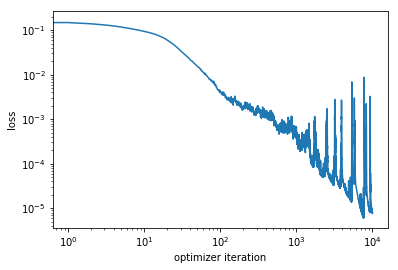

In [5]:
plt.xlabel('optimizer iteration')
plt.ylabel('loss')
plt.loglog(mse_n)

Deep-Decoder representation of the image, SNR: 52.22139740772464


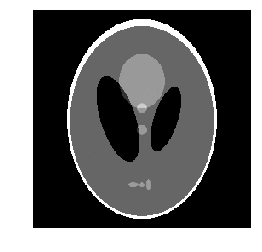

In [6]:
def myimgshow(plt,img):
    plt.gray()
    plt.imshow(np.clip(img[0],0,1),interpolation='nearest')

out_img_np = net( ni.type(dtype) ).data.cpu().numpy()[0]
maxv = np.max(img_np)
print("Deep-Decoder representation of the image, SNR: " + str(psnr(img_np,out_img_np,maxv)))
myimgshow(plt,out_img_np)
plt.axis('off')
plt.savefig('exp_vis_sub'+img_name+'_final.png')
plt.show()

## Visualize activation maps

0 last func. applied: Sigmoid()


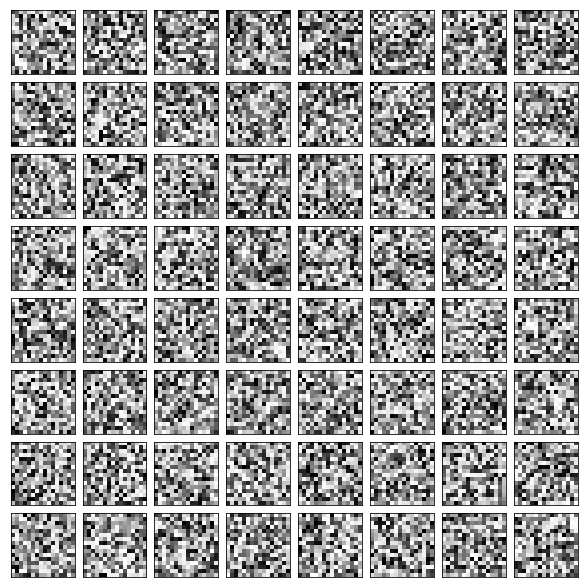

2 last func. applied: Upsample(scale_factor=2, mode=bilinear)


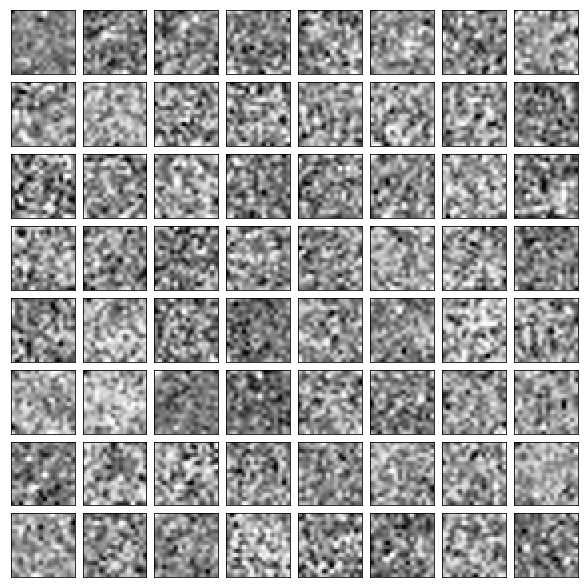

6 last func. applied: Upsample(scale_factor=2, mode=bilinear)


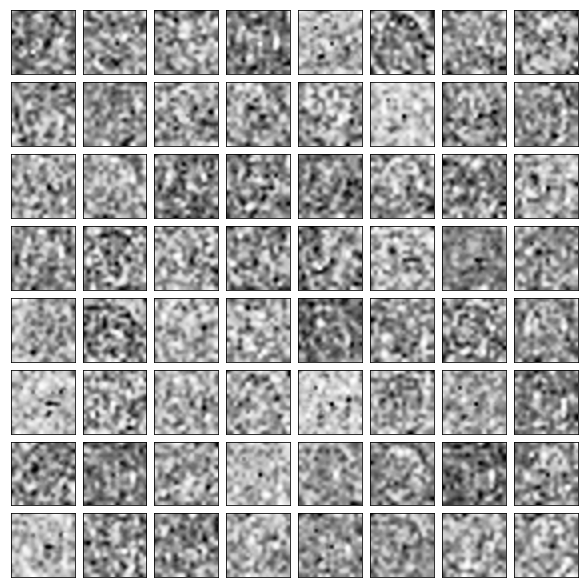

10 last func. applied: Upsample(scale_factor=2, mode=bilinear)


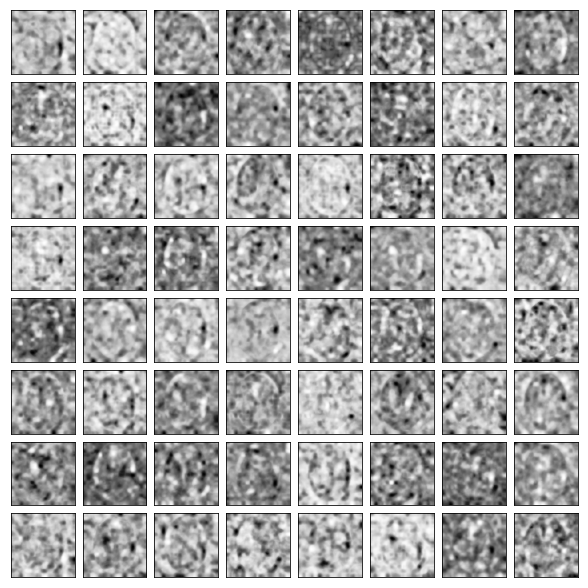

14 last func. applied: Upsample(scale_factor=2, mode=bilinear)


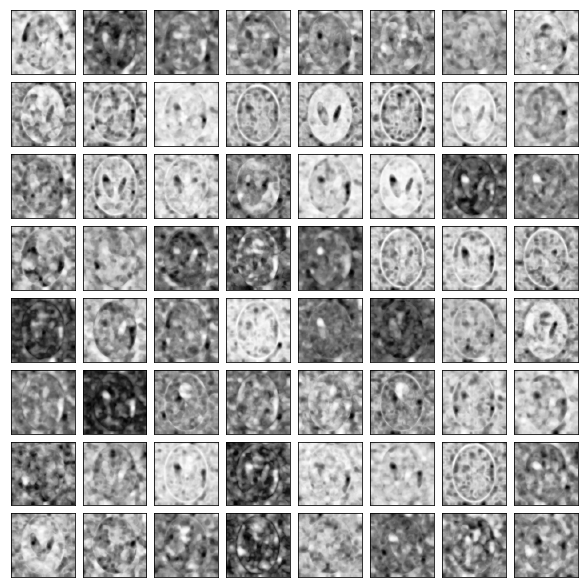

18 last func. applied: ReLU()


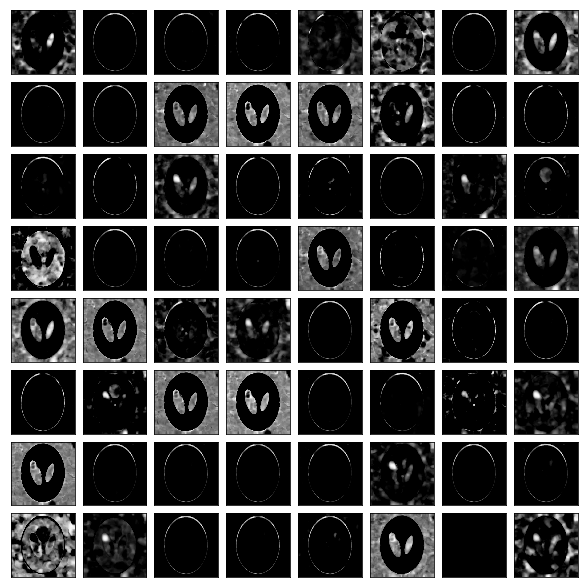

20 last func. applied: Sequential(
  (0): ReflectionPad2d((0, 0, 0, 0))
  (1): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
)


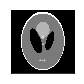

In [7]:
def apply_until(net_input,net,n = 100):
    # applies function by funtion of a network
    for i,fun in enumerate(net):
        if i>=n:
            break
        if i==0:
            out = fun(net_input.type(dtype))
        else:
            out = fun(out)
    print(i, "last func. applied:", net[i-1])
    if n == 0:
        return net_input
    else:
        return out

def plot_tensor(out,nrows=8):
    imgs = [img for img in out.data.cpu().numpy()[0]]
    fig = plot_image_grid(imgs,nrows=nrows)
    plt.show()

before_up = [1,3,7,11,15,19,23]

for n in before_up:
        out = apply_until(ni,net,n-1)
        plot_tensor(out)


In [8]:
## save images for paper
before_up = [1,3,7,11,15,19,23]
allimgs = []
nrows = 8
for i,n in enumerate(before_up):
        out = apply_until(ni,net,n-1)
        imgs = [img for img in out.data.cpu().numpy()[0]]
        imgs = imgs[:nrows]
        fig = plot_image_grid(imgs,nrows = 1 )
        plt.savefig('exp_vis_sub'+img_name+'_'+str(i)+'.png')
        plt.close()

0 last func. applied: Sigmoid()
2 last func. applied: Upsample(scale_factor=2, mode=bilinear)
6 last func. applied: Upsample(scale_factor=2, mode=bilinear)
10 last func. applied: Upsample(scale_factor=2, mode=bilinear)
14 last func. applied: Upsample(scale_factor=2, mode=bilinear)
18 last func. applied: ReLU()
20 last func. applied: Sequential(
  (0): ReflectionPad2d((0, 0, 0, 0))
  (1): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
)


# Changing the input

The deep decoder's input is fixed, and its fitted weights pertain to that input.  If, after fitting, the input is changed to different random values, then the resulting output looks like smooth noise, as expected.

Deep-Decoder representation of the image, SNR: 8.915696252210774


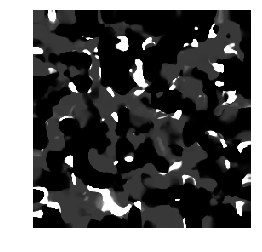

In [9]:
nin = Variable(torch.zeros(ni.shape))
nin.data.uniform_()
nin.data *= 1./10

out_img_np = net( nin.type(dtype) ).data.cpu().numpy()[0]
maxv = np.max(img_np)
print("Deep-Decoder representation of the image, SNR: " + str(psnr(img_np,out_img_np,maxv)))
myimgshow(plt,out_img_np)
plt.axis('off')
plt.show()